In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
import os
import cv2

def load_images(dirname, filetype=None, grayscale=False, size=None):
    mode = 0 if grayscale else 1
    images = []
    filenames = os.listdir(dirname)
    
    if filetype is not None:
        filenames = [filename for filename in filenames if filename.endswith('.' + filetype)]
        
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), mode)
        
        if size is not None:
            image = cv2.resize(image, size)
        
        images.append(image)
    
    return images

In [3]:
from keras.utils import to_categorical

def prepare_data(c, nc, expand_dims=False, normalization_fn=None, return_y=False, y_categorical=False):
    c  = np.array(c, dtype=np.float32) if type(c) == list else c.astype(np.float32)
    nc = np.array(nc, dtype=np.float32) if type(nc) == list else nc.astype(np.float32)
    
    X = np.concatenate((c, nc), axis=0)
    
    if expand_dims:
        X = np.expand_dims(X, axis=3)
    
    if normalization_fn is not None:        
        X = normalization_fn(X)
    
    if return_y:
        c_label  = np.ones(c.shape[0])
        nc_label = np.zeros(nc.shape[0])
        
        y = np.concatenate((c_label, nc_label), axis=0)
        
        if y_categorical:
            y = to_categorical(y)
        
        return X, y
    
    return X

Using TensorFlow backend.


## MobileNet V2

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

model = MobileNetV2(input_shape=(128, 128, 3), weights=None, classes=2)

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Treino

In [0]:
c_train  = load_images('Dataset_2/Train/C', filetype='tif', size=(128, 128))
nc_train = load_images('Dataset_2/Train/NC', filetype='tif', size=(128, 128))

c_validation  = load_images('Dataset_2/Validation/C', filetype='tif', size=(128, 128))
nc_validation = load_images('Dataset_2/Validation/NC', filetype='tif', size=(128, 128))

In [0]:
X_train, y_train = prepare_data(c_train, nc_train, normalization_fn=preprocess_input, return_y=True, y_categorical=True)
X_validation, y_validation = prepare_data(c_validation, nc_validation, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('mobilenet_v2_weights.hdf5', save_best_only=True, verbose=1)

In [10]:
training = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Train on 4276 samples, validate on 1068 samples
Epoch 1/50
4276/4276 [==============================] - 36s 8ms/step - loss: 0.3052 - acc: 0.8798 - val_loss: 0.6089 - val_acc: 0.8886

Epoch 00001: val_loss improved from inf to 0.60894, saving model to mobilenet_v2_weights.hdf5
Epoch 2/50
4276/4276 [==============================] - 24s 6ms/step - loss: 0.1670 - acc: 0.9406 - val_loss: 0.2330 - val_acc: 0.9635

Epoch 00002: val_loss improved from 0.60894 to 0.23296, saving model to mobilenet_v2_weights.hdf5
Epoch 3/50
4276/4276 [==============================] - 24s 6ms/step - loss: 0.1466 - acc: 0.9436 - val_loss: 0.5832 - val_acc: 0.8933

Epoch 00003: val_loss did not improve from 0.23296
Epoch 4/50
4276/4276 [==============================] - 23s 5ms/step - loss: 0.1199 - acc: 0.9579 - val_loss: 0.3100 - val_acc: 0.9448

Epoch 00004: val_loss did not improve from 0.23296
Epoch 5/50
4276/4276 [==============================] - 24s 6ms/step - loss: 0.1134 - acc: 0.9602 - val_loss: 0.62

### Avaliação

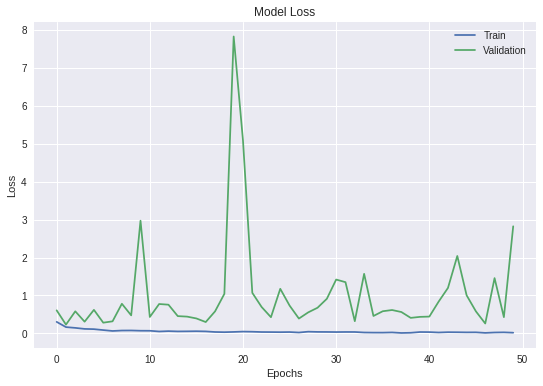

In [11]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

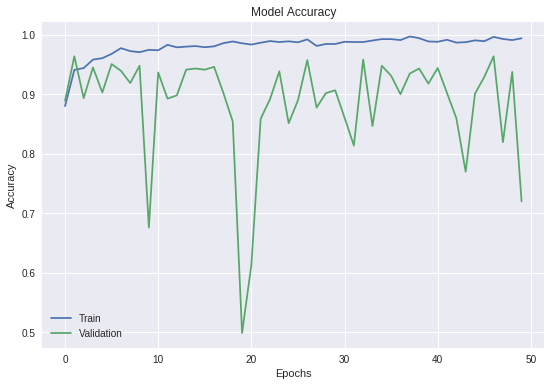

In [12]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('mobilenet_v2_weights.hdf5')

In [0]:
c_test  = load_images('Dataset_2/Test/C', filetype='tif', size=(128, 128))
nc_test = load_images('Dataset_2/Test/NC', filetype='tif', size=(128, 128))

In [0]:
X_test, y_test = prepare_data(c_test, nc_test, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [16]:
mobilenet_v2_metrics = model.evaluate(X_test, y_test)

1336/1336 [==============================] - 2s 1ms/step


In [18]:
print("Test Loss: {:.6} | Test Accuracy: {:.4}%".format(mobilenet_v2_metrics[0], mobilenet_v2_metrics[1] * 100))

Test Loss: 0.360366 | Test Accuracy: 95.28%


## Inception V3

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(input_shape=(128, 128, 3), weights=None, classes=2)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Treino

In [0]:
c_train  = load_images('Dataset_2/Train/C', filetype='tif', size=(128, 128))
nc_train = load_images('Dataset_2/Train/NC', filetype='tif', size=(128, 128))

c_validation  = load_images('Dataset_2/Validation/C', filetype='tif', size=(128, 128))
nc_validation = load_images('Dataset_2/Validation/NC', filetype='tif', size=(128, 128))

In [0]:
X_train, y_train = prepare_data(c_train, nc_train, normalization_fn=preprocess_input, return_y=True, y_categorical=True)
X_validation, y_validation = prepare_data(c_validation, nc_validation, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('inception_v3_weights.hdf5', save_best_only=True, verbose=1)

In [25]:
training = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Train on 4276 samples, validate on 1068 samples
Epoch 1/50
4276/4276 [==============================] - 67s 16ms/step - loss: 0.4217 - acc: 0.8711 - val_loss: 0.1995 - val_acc: 0.9363

Epoch 00001: val_loss improved from inf to 0.19952, saving model to inception_v3_weights.hdf5
Epoch 2/50
4276/4276 [==============================] - 47s 11ms/step - loss: 0.2403 - acc: 0.9217 - val_loss: 0.4660 - val_acc: 0.8567

Epoch 00002: val_loss did not improve from 0.19952
Epoch 3/50
4276/4276 [==============================] - 46s 11ms/step - loss: 0.2994 - acc: 0.8971 - val_loss: 0.1457 - val_acc: 0.9522

Epoch 00003: val_loss improved from 0.19952 to 0.14571, saving model to inception_v3_weights.hdf5
Epoch 4/50
4276/4276 [==============================] - 46s 11ms/step - loss: 0.2731 - acc: 0.9172 - val_loss: 0.2532 - val_acc: 0.9345

Epoch 00004: val_loss did not improve from 0.14571
Epoch 5/50
4276/4276 [==============================] - 47s 11ms/step - loss: 0.3039 - acc: 0.8842 - val_loss:

### Avaliação

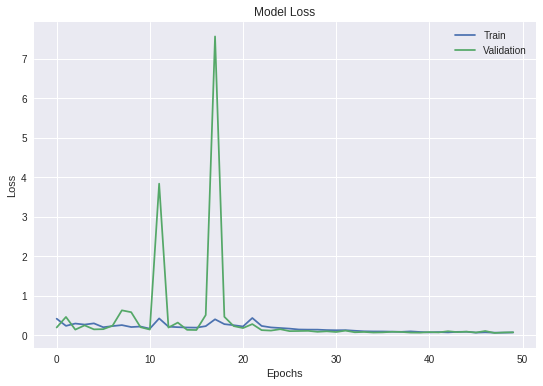

In [26]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

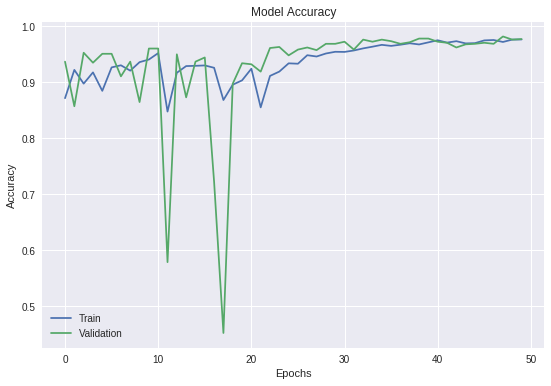

In [27]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('inception_v3_weights.hdf5')

In [0]:
c_test  = load_images('Dataset_2/Test/C', filetype='tif', size=(128, 128))
nc_test = load_images('Dataset_2/Test/NC', filetype='tif', size=(128, 128))

In [0]:
X_test, y_test = prepare_data(c_test, nc_test, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [31]:
inception_v3_metrics = model.evaluate(X_test, y_test)

1336/1336 [==============================] - 4s 3ms/step


In [32]:
print("Test Loss: {:.6} | Test Accuracy: {:.4}%".format(inception_v3_metrics[0], inception_v3_metrics[1] * 100))

Test Loss: 0.0557643 | Test Accuracy: 98.13%


## VGG16

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model = VGG16(input_shape=(128, 128, 3), weights=None, classes=2)

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Treino

In [0]:
c_train  = load_images('Dataset_2/Train/C', filetype='tif', size=(128, 128))
nc_train = load_images('Dataset_2/Train/NC', filetype='tif', size=(128, 128))

c_validation  = load_images('Dataset_2/Validation/C', filetype='tif', size=(128, 128))
nc_validation = load_images('Dataset_2/Validation/NC', filetype='tif', size=(128, 128))

In [0]:
X_train, y_train = prepare_data(c_train, nc_train, normalization_fn=preprocess_input, return_y=True, y_categorical=True)
X_validation, y_validation = prepare_data(c_validation, nc_validation, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('vgg16_weights.hdf5', save_best_only=True, verbose=1)

In [39]:
training = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Train on 4276 samples, validate on 1068 samples
Epoch 1/50
4276/4276 [==============================] - 66s 15ms/step - loss: 8.0001 - acc: 0.5002 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 8.05905, saving model to vgg16_weights.hdf5
Epoch 2/50
4276/4276 [==============================] - 52s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 8.05905
Epoch 3/50
4276/4276 [==============================] - 52s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 8.05905
Epoch 4/50
4276/4276 [==============================] - 52s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 8.05905
Epoch 5/50
4276/4276 [==============================] - 52s 12ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00005: val_loss did n

### Avaliação

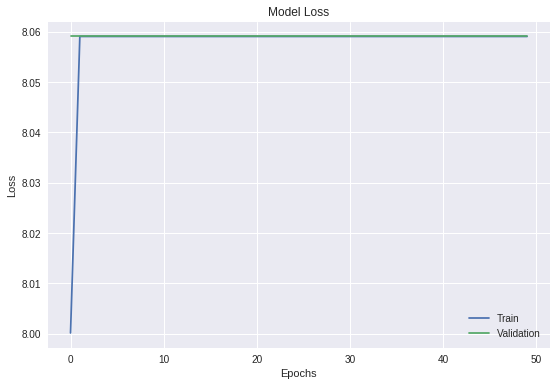

In [40]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

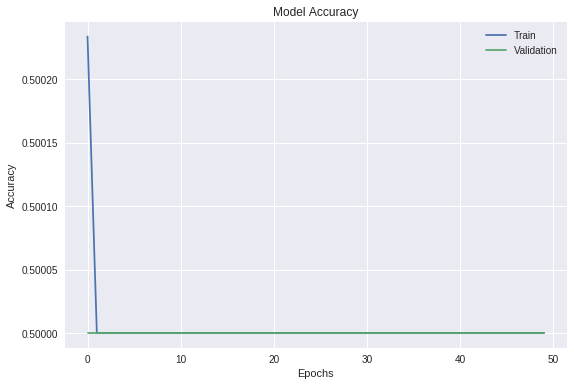

In [41]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('vgg16_weights.hdf5')

In [0]:
c_test  = load_images('Dataset_2/Test/C', filetype='tif', size=(128, 128))
nc_test = load_images('Dataset_2/Test/NC', filetype='tif', size=(128, 128))

In [0]:
X_test, y_test = prepare_data(c_test, nc_test, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [48]:
vgg16_metrics = model.evaluate(X_test, y_test)

1336/1336 [==============================] - 4s 3ms/step


In [49]:
print("Test Loss: {:.6} | Test Accuracy: {:.4}%".format(vgg16_metrics[0], vgg16_metrics[1] * 100))

Test Loss: 8.05905 | Test Accuracy: 50.0%


## VGG19

In [0]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

model = VGG19(input_shape=(128, 128, 3), weights=None, classes=2)

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Treino

In [0]:
c_train  = load_images('Dataset_2/Train/C', filetype='tif', size=(128, 128))
nc_train = load_images('Dataset_2/Train/NC', filetype='tif', size=(128, 128))

c_validation  = load_images('Dataset_2/Validation/C', filetype='tif', size=(128, 128))
nc_validation = load_images('Dataset_2/Validation/NC', filetype='tif', size=(128, 128))

In [0]:
X_train, y_train = prepare_data(c_train, nc_train, normalization_fn=preprocess_input, return_y=True, y_categorical=True)
X_validation, y_validation = prepare_data(c_validation, nc_validation, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('vgg19_weights.hdf5', save_best_only=True, verbose=1)

In [56]:
training = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Train on 4276 samples, validate on 1068 samples
Epoch 1/50
4276/4276 [==============================] - 67s 16ms/step - loss: 8.0077 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 8.05905, saving model to vgg19_weights.hdf5
Epoch 2/50
4276/4276 [==============================] - 60s 14ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 8.05905
Epoch 3/50
4276/4276 [==============================] - 59s 14ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 8.05905
Epoch 4/50
4276/4276 [==============================] - 59s 14ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 8.05905
Epoch 5/50
4276/4276 [==============================] - 59s 14ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00005: val_loss did n

### Avaliação

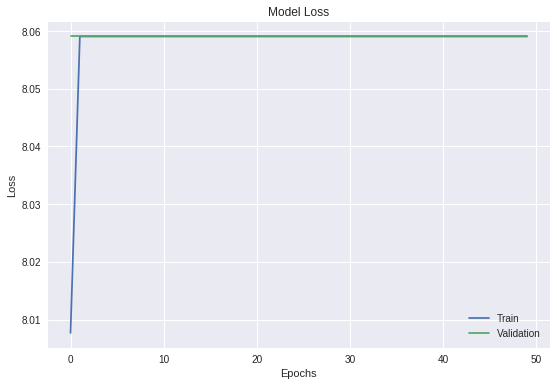

In [57]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

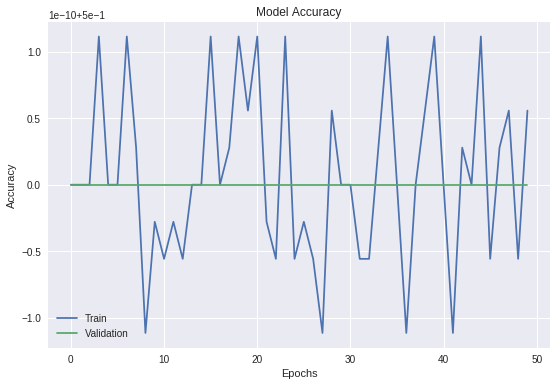

In [58]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('vgg19_weights.hdf5')

In [0]:
c_test  = load_images('Dataset_2/Test/C', filetype='tif', size=(128, 128))
nc_test = load_images('Dataset_2/Test/NC', filetype='tif', size=(128, 128))

In [0]:
X_test, y_test = prepare_data(c_test, nc_test, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [62]:
vgg19_metrics = model.evaluate(X_test, y_test)

1336/1336 [==============================] - 5s 4ms/step


In [63]:
print("Test Loss: {:.6} | Test Accuracy: {:.4}%".format(vgg19_metrics[0], vgg19_metrics[1] * 100))

Test Loss: 8.05905 | Test Accuracy: 50.0%


## DenseNet121

In [0]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

model = DenseNet121(input_shape=(128, 128, 3), weights=None, classes=2)

In [65]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Treino

In [0]:
c_train  = load_images('Dataset_2/Train/C', filetype='tif', size=(128, 128))
nc_train = load_images('Dataset_2/Train/NC', filetype='tif', size=(128, 128))

c_validation  = load_images('Dataset_2/Validation/C', filetype='tif', size=(128, 128))
nc_validation = load_images('Dataset_2/Validation/NC', filetype='tif', size=(128, 128))

In [0]:
X_train, y_train = prepare_data(c_train, nc_train, normalization_fn=preprocess_input, return_y=True, y_categorical=True)
X_validation, y_validation = prepare_data(c_validation, nc_validation, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('densenet121_weights.hdf5', save_best_only=True, verbose=1)

In [70]:
training = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_validation, y_validation), callbacks=[checkpointer])

Train on 4276 samples, validate on 1068 samples
Epoch 1/50
4276/4276 [==============================] - 94s 22ms/step - loss: 0.2591 - acc: 0.9104 - val_loss: 0.2673 - val_acc: 0.9017

Epoch 00001: val_loss improved from inf to 0.26730, saving model to densenet121_weights.hdf5
Epoch 2/50
4276/4276 [==============================] - 58s 14ms/step - loss: 0.2219 - acc: 0.9158 - val_loss: 2.5761 - val_acc: 0.7397

Epoch 00002: val_loss did not improve from 0.26730
Epoch 3/50
4276/4276 [==============================] - 58s 14ms/step - loss: 0.1836 - acc: 0.9331 - val_loss: 0.1304 - val_acc: 0.9597

Epoch 00003: val_loss improved from 0.26730 to 0.13036, saving model to densenet121_weights.hdf5
Epoch 4/50
4276/4276 [==============================] - 58s 14ms/step - loss: 0.1743 - acc: 0.9406 - val_loss: 0.4244 - val_acc: 0.9457

Epoch 00004: val_loss did not improve from 0.13036
Epoch 5/50
4276/4276 [==============================] - 57s 13ms/step - loss: 0.1838 - acc: 0.9345 - val_loss: 0

### Avaliação

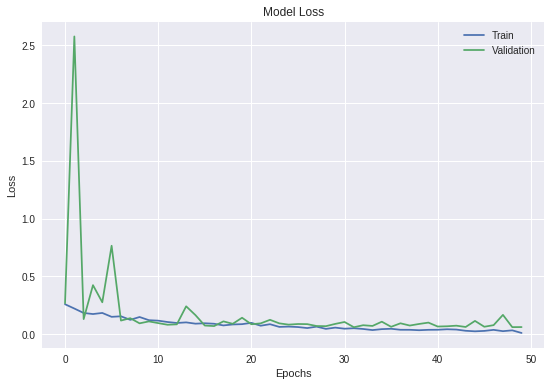

In [71]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

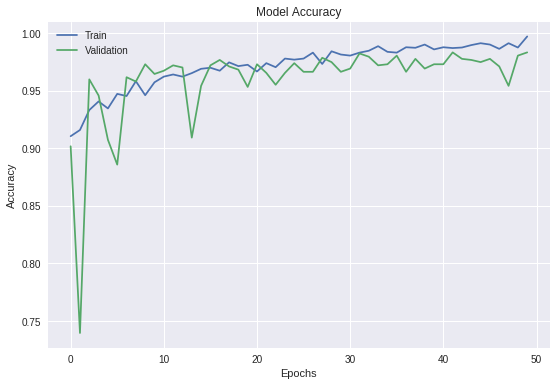

In [72]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('densenet121_weights.hdf5')

In [0]:
c_test  = load_images('Dataset_2/Test/C', filetype='tif', size=(128, 128))
nc_test = load_images('Dataset_2/Test/NC', filetype='tif', size=(128, 128))

In [0]:
X_test, y_test = prepare_data(c_test, nc_test, normalization_fn=preprocess_input, return_y=True, y_categorical=True)

In [76]:
densenet121_metrics = model.evaluate(X_test, y_test)

1336/1336 [==============================] - 5s 4ms/step


In [77]:
print("Test Loss: {:.6} | Test Accuracy: {:.4}%".format(densenet121_metrics[0], densenet121_metrics[1] * 100))

Test Loss: 0.054436 | Test Accuracy: 98.35%
